In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random
import re
from tqdm import tqdm
import seaborn as sns
from sklearn import metrics
import time
import copy

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
# torch.backends controls the behavior of various backends that PyTorch supports.
# A bool that, if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.
torch.backends.cudnn.benchmark = False

# A bool that, if True, causes cuDNN to only use deterministic convolution algorithms.
torch.backends.cudnn.deterministic = True

In [3]:
SAVE_PATH = './model_checkpoints'
BATCH_SIZE = 256 #@param number

In [4]:
# get all filenames from thing
# build a map of all files
# evenly split data into 75 15 10
# save files as 0001_<target>.jpg so it can easily be sorted
# in dataset loader, pre-load the map from index to filename
import os
from sklearn.model_selection import train_test_split

def split_data():
  t_n = 0
  v_n = 0
  e_n = 0
  for target in os.listdir('./data/asl_alphabet_train'):
    target_path = f'./data/asl_alphabet_train/{target}'
    target_files = os.listdir(target_path)

    train, rest = train_test_split(target_files, test_size=0.25, shuffle=True, random_state=42)
    val, test = train_test_split(rest, test_size=0.1/0.25, shuffle=True, random_state=42)

    for file in train:
      num = ("000000" + str(t_n))[-6:]
      t_n += 1
      os.rename(f'{target_path}/{file}', f'./data/train/{num}_{target}.jpg')
    for file in val:
      num = ("000000" + str(v_n))[-6:]
      v_n += 1
      os.rename(f'{target_path}/{file}', f'./data/val/{num}_{target}.jpg')
    for file in test:
      num = ("000000" + str(e_n))[-6:]
      e_n += 1
      os.rename(f'{target_path}/{file}', f'./data/test/{num}_{target}.jpg')

# split_data()

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ASLDataset(Dataset):
  # 15000 images take up ~10GB in RAM
  def __init__(self, data_path, preload=False):
    super().__init__()
    self.preload = preload
    self.data_path = data_path
    self.target_map = {'space': 0, 'A': 1, 'S': 2, 'G': 3, 'U': 4, 'W': 5, 'R': 6, 'N': 7, 'Q': 8, 'L': 9, 'B': 10, 'J': 11, 'nothing': 12, 'Z': 13, 'T': 14, 'P': 15, 'K': 16, 'V': 17, 'D': 18, 'X': 19, 'F': 20, 'E': 21, 'M': 22, 'C': 23, 'H': 24, 'O': 25, 'I': 26, 'Y': 27, 'del': 28}
    self.data = []
    if preload:
      for file in tqdm(os.listdir(data_path)):
        self.data.append(self.load_image(file))

  def __len__(self):
    if self.preload:
      return len(self.data)
    else:
      return len(os.listdir(self.data_path))

  def __getitem__(self, idx):
    if self.preload:
      return self.data[idx]

    idx = ('00000' + str(idx))[-6:]
    filename = [filename for filename in os.listdir(self.data_path) if filename.startswith(idx)][0]
    return self.load_image(filename)

  def get_target_map(self):
    return self.target_map

  def load_image(self, filename):
    image = Image.open(os.path.join(self.data_path, filename))
    target = re.search(r"(?<=_)\w*?(?=\.)", filename).group(0)
    target = self.target_map[target]
    return ToTensor()(image), target

data_dir = './data'
image_datasets = {
  x: ASLDataset(os.path.join(data_dir, x)) for x in ['train', 'val', 'test']
}
dataloaders = {
  x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=16) for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      print(f"Phase: {phase}")
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [8]:
#Load in a pre-trained model: efficient net
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# freeze all parameters of the model
for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(1280, len(image_datasets['train'].get_target_map())),
    )
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Phase: train


100%|██████████| 255/255 [01:55<00:00,  2.22it/s]


train Loss: 0.3539 Acc: 0.9275
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.80it/s]


val Loss: 0.1915 Acc: 0.9651

Epoch 1/24
----------
Phase: train


100%|██████████| 255/255 [01:55<00:00,  2.22it/s]


train Loss: 0.2894 Acc: 0.9362
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.75it/s]


val Loss: 0.1501 Acc: 0.9730

Epoch 2/24
----------
Phase: train


100%|██████████| 255/255 [01:55<00:00,  2.20it/s]


train Loss: 0.2478 Acc: 0.9425
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.85it/s]


val Loss: 0.1262 Acc: 0.9765

Epoch 3/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.24it/s]


train Loss: 0.2199 Acc: 0.9479
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.74it/s]


val Loss: 0.1107 Acc: 0.9789

Epoch 4/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.26it/s]


train Loss: 0.2053 Acc: 0.9509
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.81it/s]


val Loss: 0.1069 Acc: 0.9800

Epoch 5/24
----------
Phase: train


100%|██████████| 255/255 [01:51<00:00,  2.28it/s]


train Loss: 0.2009 Acc: 0.9531
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.78it/s]


val Loss: 0.1030 Acc: 0.9810

Epoch 6/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.28it/s]


train Loss: 0.2000 Acc: 0.9531
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.94it/s]


val Loss: 0.1047 Acc: 0.9798

Epoch 7/24
----------
Phase: train


100%|██████████| 255/255 [01:51<00:00,  2.29it/s]


train Loss: 0.1959 Acc: 0.9550
Phase: val


100%|██████████| 51/51 [00:08<00:00,  6.15it/s]


val Loss: 0.1007 Acc: 0.9810

Epoch 8/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.26it/s]


train Loss: 0.1968 Acc: 0.9529
Phase: val


100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


val Loss: 0.1003 Acc: 0.9811

Epoch 9/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.24it/s]


train Loss: 0.1956 Acc: 0.9530
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.80it/s]


val Loss: 0.0992 Acc: 0.9815

Epoch 10/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.27it/s]


train Loss: 0.1935 Acc: 0.9545
Phase: val


100%|██████████| 51/51 [00:08<00:00,  6.01it/s]


val Loss: 0.0995 Acc: 0.9813

Epoch 11/24
----------
Phase: train


100%|██████████| 255/255 [01:54<00:00,  2.23it/s]


train Loss: 0.1945 Acc: 0.9537
Phase: val


100%|██████████| 51/51 [00:08<00:00,  6.13it/s]


val Loss: 0.0999 Acc: 0.9809

Epoch 12/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.25it/s]


train Loss: 0.1931 Acc: 0.9542
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.80it/s]


val Loss: 0.0990 Acc: 0.9813

Epoch 13/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.25it/s]


train Loss: 0.1930 Acc: 0.9544
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.74it/s]


val Loss: 0.0979 Acc: 0.9819

Epoch 14/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.26it/s]


train Loss: 0.1923 Acc: 0.9547
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.84it/s]


val Loss: 0.0984 Acc: 0.9811

Epoch 15/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.25it/s]


train Loss: 0.1929 Acc: 0.9539
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.78it/s]


val Loss: 0.0991 Acc: 0.9816

Epoch 16/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.25it/s]


train Loss: 0.1938 Acc: 0.9532
Phase: val


100%|██████████| 51/51 [00:09<00:00,  5.67it/s]


val Loss: 0.0984 Acc: 0.9816

Epoch 17/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.26it/s]


train Loss: 0.1913 Acc: 0.9547
Phase: val


100%|██████████| 51/51 [00:09<00:00,  5.67it/s]


val Loss: 0.0999 Acc: 0.9812

Epoch 18/24
----------
Phase: train


100%|██████████| 255/255 [01:54<00:00,  2.22it/s]


train Loss: 0.1933 Acc: 0.9535
Phase: val


100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


val Loss: 0.0993 Acc: 0.9817

Epoch 19/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.27it/s]


train Loss: 0.1927 Acc: 0.9538
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.77it/s]


val Loss: 0.0987 Acc: 0.9812

Epoch 20/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.27it/s]


train Loss: 0.1945 Acc: 0.9533
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.69it/s]


val Loss: 0.1001 Acc: 0.9811

Epoch 21/24
----------
Phase: train


100%|██████████| 255/255 [01:52<00:00,  2.26it/s]


train Loss: 0.1921 Acc: 0.9545
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.75it/s]


val Loss: 0.1005 Acc: 0.9811

Epoch 22/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.25it/s]


train Loss: 0.1918 Acc: 0.9549
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.73it/s]


val Loss: 0.1009 Acc: 0.9810

Epoch 23/24
----------
Phase: train


100%|██████████| 255/255 [01:55<00:00,  2.21it/s]


train Loss: 0.1924 Acc: 0.9549
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.71it/s]


val Loss: 0.0983 Acc: 0.9819

Epoch 24/24
----------
Phase: train


100%|██████████| 255/255 [01:53<00:00,  2.24it/s]


train Loss: 0.1930 Acc: 0.9546
Phase: val


100%|██████████| 51/51 [00:08<00:00,  5.70it/s]

val Loss: 0.0985 Acc: 0.9811

Training complete in 50m 56s
Best val Acc: 0.981916


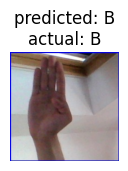

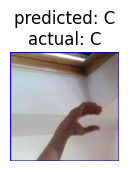

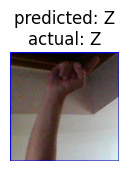

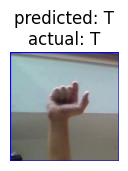

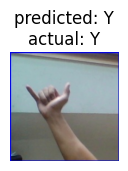

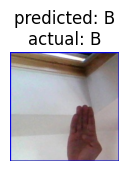

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    class_names = list(image_datasets['train'].get_target_map().keys())

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

In [20]:
# Checkpoint
torch.save({
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict()
}, f'{SAVE_PATH}.pt')

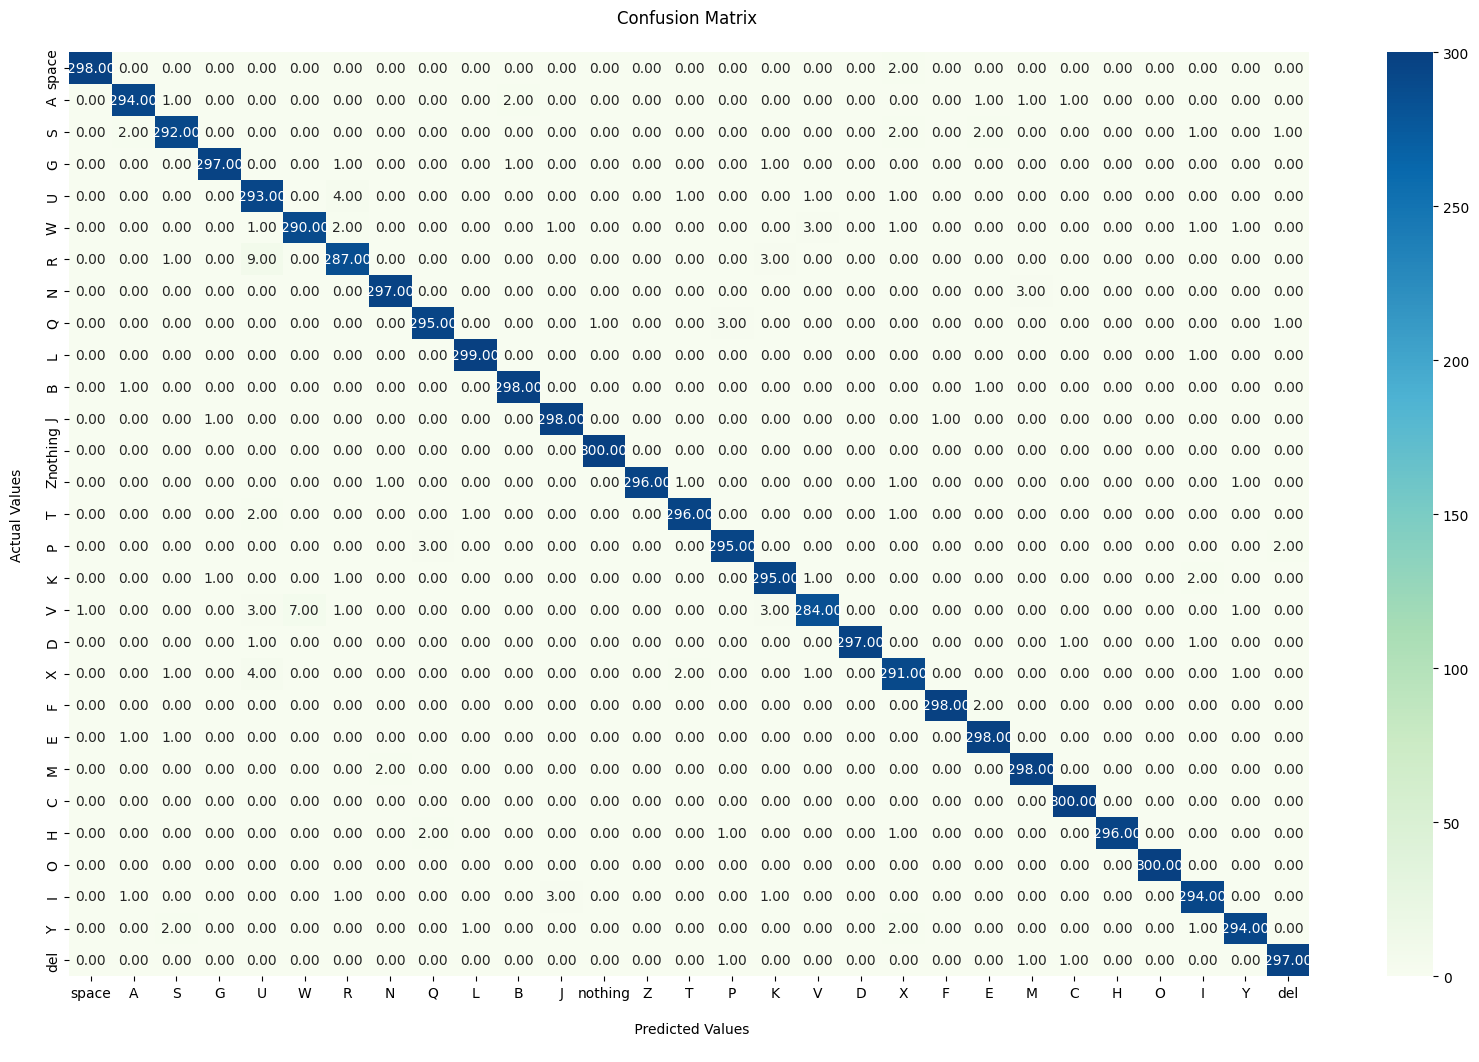

In [38]:
def conf_matrix(model):
  was_training = model.training
  model.eval()
  class_names = list(image_datasets['train'].get_target_map().keys())

  all_pred = np.empty(0)
  all_labels = np.empty(0)
  with torch.no_grad():
    for inputs, labels in dataloaders['test']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      all_pred = np.concatenate((all_pred, preds.cpu().numpy()))
      all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

  plt.figure(figsize=(20,12))
  fx=sns.heatmap(metrics.confusion_matrix(all_labels,all_pred), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n')
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n')
  fx.xaxis.set_ticklabels(class_names)
  fx.yaxis.set_ticklabels(class_names)
  plt.show()

  model.train(mode=was_training)

conf_matrix(model)